## Example 2.
### Sensitivity of hydraulic head at a point to <font color='blue'>spatially uniform recharge</font> under steady state flow conditions

## 0. Forward model
<br>
Governing equation:

$\begin{align}
\quad\quad K\ b\ \frac{d^2h}{dx^2}+R=0\cr
\cr\end{align}$

Boundary conditions:

$\begin{align}
\quad\quad -K\ b\ \frac{dh(x)}{dx}=0\ ,\quad\quad\;\;\, x=0=\Gamma_2\cr
\end{align}$

$\begin{align}
\quad\quad h(x)=h_{\Gamma_1}\ ,\quad\quad\quad\quad\quad x=L=\Gamma_1\cr
\cr\end{align}$

Closed-form solution:

$\begin{align}
\quad\quad h(x)=h_L+\frac{R (L^2-x^2)}{2\ K\ b}
\cr\cr\end{align}$

Spatial derivatives from differentiation:

$\begin{align}
\quad\quad \frac{d h}{d x}=-\frac{R\ x}{K\ b},\quad\quad \frac{d^2 h}{d x^2}{}=-\frac{R}{K\ b}
\cr\end{align}$

In [1]:
from IPython.display import HTML, display
def set_background(color):
    script = (
        "var cell = this.closest('.code_cell');"
        "var editor = cell.querySelector('.input_area');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)").format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

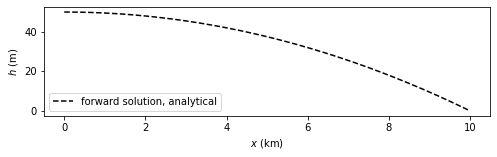

In [28]:
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)

import numpy as np

def h(x, K, R, b, L, BC1h):
    return R/K/2./b*(L**2.-x**2.)

K, R, b, L, BC1h, ocol = 10., 1e-1/1000., 10., 10000., 0., 5000
X = np.arange(L)
H0 = np.array([h(x, K, R, b, L, BC1h) for x in X])

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., H0, 'k--', mfc='none', label='forward solution, analytical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend(loc=3);

## 1. Direct sensitivity
$\begin{align}\cr
\frac{\partial h(x')}{\partial R}=\frac{L^2-x^2}{2\ K\ b}
\cr\cr\end{align}$

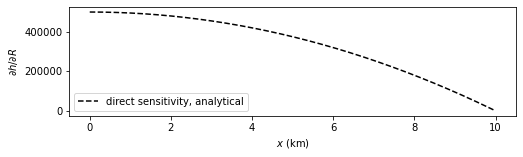

In [29]:
dhdR = [(L**2.-x**2.)/(2.*K*b) for x in X]
benchmark = dhdR[ocol]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdR, 'k--', mfc='none', label='direct sensitivity, analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial R$')
plt.legend(loc=3);

In [30]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f (%.6f)'% (dhdR[ocol], benchmark))

375000.000000 (375000.000000)


## 2. Perturbation sensitivity
$\begin{align}\cr
\frac{\partial h(x')}{\partial R}\approx\frac{h(x,K+\Delta R)-h(x,R)}{\Delta R}\;
\cr\cr\end{align}$

### 2a. Analytical

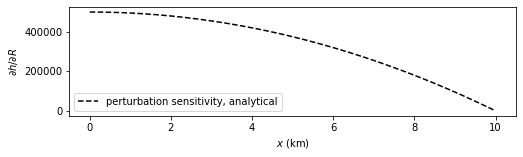

In [31]:
dpar = 1e-4
H0 = np.array([h(x, K, R, b, L, BC1h) for x in X])
H1 = np.array([h(x, K, R+R*dpar, b, L, BC1h) for x in X])
dhdR = (H1-H0)/(R*dpar)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdR, 'k--', mfc='none', label='perturbation sensitivity, analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial R$')
plt.legend(loc=3);

In [32]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f (%.6f)'% (dhdR[ocol], benchmark))

374999.999999 (375000.000000)


### 2b. Semi-analytical

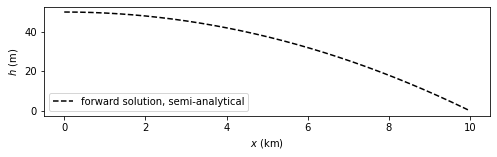

In [33]:
from os import getcwd, chdir
cwd = getcwd()
chdir(r'../../timml')
import timml
chdir(cwd)

M0 = timml.Model3D(kaq=K, z=[0., -b])
timml.ImpLineDoublet1D(M0, xld=0.)
timml.HeadLineSink1D(M0, xls=L, hls=0.)
timml.StripAreaSink(M0, 0., L, R)
M0.solve(silent=True)
H0 = M0.headalongline(X, 0.).flatten()

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., H0, 'k--', mfc='none', label='forward solution, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend(loc=3);

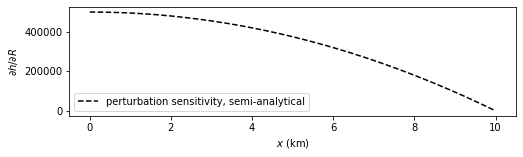

In [34]:
M1 = timml.Model3D(kaq=K, z=[0., -b])
timml.ImpLineDoublet1D(M1, xld=0.)
timml.HeadLineSink1D(M1, xls=L, hls=0.)
timml.StripAreaSink(M1, 0., L, R+R*dpar)
M1.solve(silent=True)
H1 = M1.headalongline(X, 0.).flatten()
dhdR = (H1-H0)/(R*dpar)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdR, 'k--', mfc='none', label='perturbation sensitivity, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial R$')
plt.legend(loc=3);

In [35]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f (%.6f)'% (dhdR[ocol], benchmark))

375000.000000 (375000.000000)


### 2c. Numerical

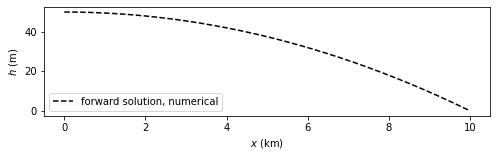

In [36]:
import flopy

nrow, ncol = 1, int(L)
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=nrow, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.hstack([np.ones([nrow, ncol-1], dtype=int), -1*np.ones([1,1])]), 
                         strt=BC1h*np.ones([nrow, ncol], dtype=float))
flopy.modflow.ModflowLpf(M0, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowRch(M0, nrchop=1, rech=R, ipakcb=53)
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
success, buff = M0.run_model(silent=True)
H0 = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., H0, 'k--', mfc='none', label='forward solution, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend(loc=3);

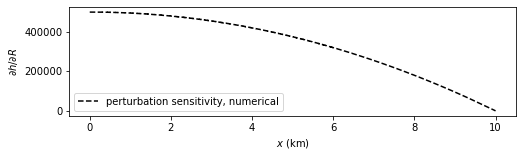

In [37]:
M1 = M0
flopy.modflow.ModflowRch(M1, nrchop=1, rech=R+R*dpar, ipakcb=53)
M1.write_input()
success, buff = M1.run_model(silent=True)
H1 = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]
dhdR = (H1-H0)/(R*dpar)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdR, 'k--', mfc='none', label='perturbation sensitivity, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial R$')
plt.legend(loc=3);

In [38]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f (%.6f)'% (dhdR[ocol], benchmark))

374984.750000 (375000.000000)


## 3. Adjoint sensitivity

<br>
    
$\begin{align}
\quad\quad \frac{\partial h(x')}{\partial R}=\int\limits_X\psi^*_1(x)\; dx
\cr\end{align}$

Governing equation:

$\begin{align}
\quad\quad K\ b\ \frac{d\psi^*_1}{dx}+\frac{1}{2\ K\ b}\delta(x-x')=0\cr
\cr\end{align}$

Boundary conditions: 

$\begin{align}
\quad\quad -K\ b\ \frac{d\psi^*_1(x)}{dx}=0\ ,\quad\quad\; x=0=\Gamma_2\cr
\end{align}$

$\begin{align}
\quad\quad \psi^*_1(x)=0\ ,\ \quad\quad\quad\quad\quad x=L=\Gamma_1\cr
\cr\end{align}$

Closed-form solution:

$\begin{align}
\quad\quad \psi^*_1(x)=\frac{1}{2\ K\ b}\left[H\left(x'-x\right)\left(L-x'\right)+H\left(x-x'\right)\left(L-x\right)\right]
\cr\end{align}$

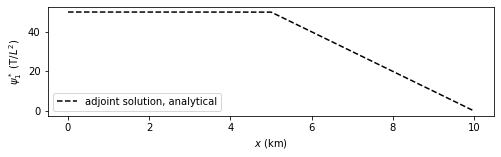

In [39]:
def a(x, xp, K, b, L):
    if x>xp:
        a = L-x
    else:
        a = L-xp
    return a/K/b
A = np.array([a(x, float(ocol), K, b, L) for x in X])

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., A, 'k--', mfc='none', label='adjoint solution, analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\psi^*_1$ (T/$L^2$)')
plt.legend(loc=3);

### 3a. Analytical

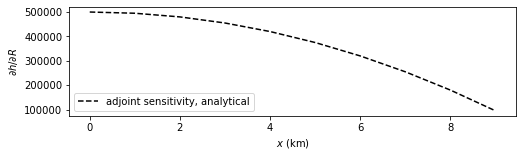

In [40]:
dhdR = [np.sum([a(x, xp, K, b, L) for x in X]) for xp in X[::1000]]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X[::1000]/1000., dhdR, 'k--', mfc='none', label='adjoint sensitivity, analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial R$')
plt.legend(loc=3);

In [41]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f (%.6f)'% (dhdR[int(np.where(X[::1000]==float(ocol))[0])], benchmark))

375025.000000 (375000.000000)


### 3b. Semi-analytical

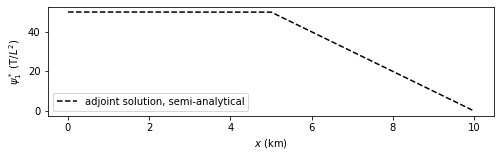

In [42]:
M0 = timml.Model3D(kaq=K, z=[0., -b])
timml.ImpLineDoublet1D(M0, xld=0.)
timml.HeadLineSink1D(M0, xls=L, hls=0.)
timml.LineSink1D(M0, xls=float(ocol), sigls=-1.)
M0.solve(silent=True)
A = M0.headalongline(X, 0.).flatten()

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., A, 'k--', mfc='none', label='adjoint solution, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\psi^*_1$ (T/$L^2$)')
plt.legend(loc=3);

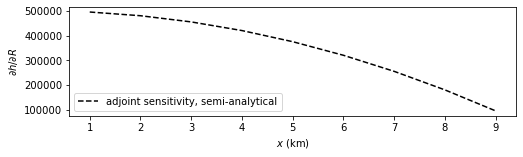

In [43]:
dhdR = np.empty(0)
for xp in X[::1000]:
    M0 = timml.Model3D(kaq=K, z=[0., -b])
    timml.ImpLineDoublet1D(M0, xld=0.)
    timml.HeadLineSink1D(M0, xls=L, hls=0.)
    timml.LineSink1D(M0, xls=xp, sigls=-1.)
    M0.solve(silent=True)
    A = M0.headalongline(X, 0.).flatten()  
    dhdR = np.append(dhdR, np.sum(A))

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X[::1000][1:]/1000., dhdR[1:], 'k--', mfc='none', label='adjoint sensitivity, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial R$')
plt.legend(loc=3);

In [44]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f (%.6f)'% (dhdR[int(np.where(X[::1000]==float(ocol))[0])], benchmark))

375025.000000 (375000.000000)


### 3c. Numerical

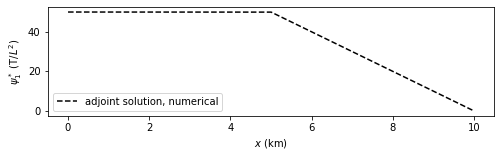

In [45]:
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=1, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.hstack([np.ones([nrow, ncol-1], dtype=int), -1*np.ones([1,1])]), 
                         strt=np.zeros([nrow, ncol], dtype=float))
flopy.modflow.ModflowLpf(M0, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowWel(M0, stress_period_data={0: [0, 0, ocol, 1.]})
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
success, buff = M0.run_model(silent=True)
A = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., A, 'k--', mfc='none', label='adjoint solution, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\psi^*_1$ (T/$L^2$)')
plt.legend(loc=3);

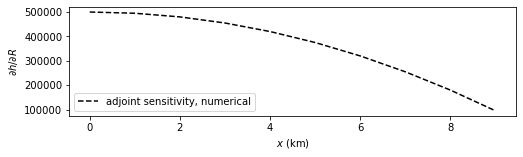

In [46]:
dhdR = np.empty(0)
for oc,xp in enumerate(X[::1000]):
    M1 = M0
    flopy.modflow.ModflowWel(M1, stress_period_data={0: [0, 0, oc*1000, 1.]})
    M1.write_input()
    success, buff = M1.run_model(silent=True)
    A = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]
    dhdR = np.append(dhdR, np.sum(A))

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
f,s = plt.subplots(figsize=[8,2])
plt.plot(X[::1000]/1000., dhdR, 'k--', mfc='none', label='adjoint sensitivity, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial R$')
plt.legend(loc=3);

In [47]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f (%.6f)'% (dhdR[int(np.where(X[::1000]==float(ocol))[0])], benchmark))

374924.968750 (375000.000000)


### 3d. Numerical, discrete

Re-run adjoint model to obtain the adjoint state vector, $\psi^*_1$:

In [48]:
M1 = M0
flopy.modflow.ModflowWel(M1, stress_period_data={0: [0, 0, ocol, 1.]})
M1.write_input()
success, buff = M1.run_model(silent=True)
psi = np.atleast_2d(flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:])
np.shape(psi)

(1, 10000)

Re-run forward model to obtain vectors of output heads, $h$, cell-by-cell conductances, $CR$, and RHS terms, $RHS$ :

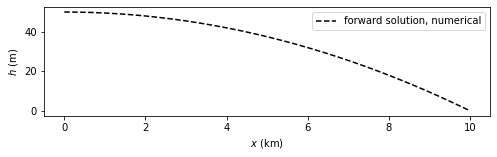

In [49]:
import flopy
from os import system

nrow, ncol = 1, int(L)
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=nrow, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.hstack([np.ones([nrow, ncol-1], dtype=int), -1*np.ones([1,1])]), 
                         strt=BC1h*np.ones([nrow, ncol], dtype=float))
flopy.modflow.ModflowLpf(M0, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowRch(M0, nrchop=1, rech=R, ipakcb=53)
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
#success, buff = M0.run_model(silent=True)
system('mf2005_stream.exe < model.in')
h = np.atleast_2d(flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:])

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
#plt.plot(X/1000., h[0, range(500, np.shape(h)[1], 1000)], 'ko--', mfc='none', label='forward solution, numerical')
plt.plot(X/1000., np.ravel(h), 'k--', mfc='none', label='forward solution, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend();

Import RHS vector:

In [50]:
RHS = np.atleast_2d(np.loadtxt('RHS.arr').flatten())
print(np.shape(RHS))

(1, 10000)


Assemble d(RHS)/dR vector analytically:

In [51]:
dRHSdR = RHS/R

In [52]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f (%.6f)'% (np.float(-psi@dRHSdR.T), benchmark))

374925.008392 (375000.000000)


In [53]:
dRHSdR


array([[-1., -1., -1., ..., -1., -1.,  0.]])